# 2016C - Abstract

### 1.数据处理
首先连接两个表

然后删去缺失数据过多的行

参数合并：线性拟合＋PCA

填补缺失值：K均值聚类，缺失值用同一类的均值填补

数据归一化

### 2.构建ROI模型

利润/投入 * 紧急程度

AHP层次分析法：衡量权重

灰色理论，利用过去五年数据预测未来五年数据

### 3.建立一年的基础模型

构建ROI和风险值指标

使用MILP(mixed integer linear programming)求解

### 4.时间序列预测

加入时间因子，改进为时间序列模型

### 5.灵敏度分析

分别改变学校数量、最大可接受风险、金钱分配的时间安排、观察最大收益的变化幅度，以验证4中策略的可行性和算法的鲁棒性。

# 导包

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import plotly as py
import seaborn as sns 
import matplotlib as mpl
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from numpy import where
from numpy import array
from numpy import unique
from numpy import hstack
from pyscipopt import Model
from matplotlib import pyplot
from scipy.stats import zscore
from pyscipopt import quicksum
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 忽略警告信息
warnings.filterwarnings("ignore")

# 初始化 Plotly 在 Jupyter Notebook 中的使用模式
py.offline.init_notebook_mode(connected = True)

# 数据处理
读取候选学校名单和学校的参数列表

In [2]:
# 读取 Excel 文件 'Problem C - IPEDS UID for Potential Candidate Schools.xlsx' 并将其存储在 data1 变量中，并输出 data1 数据框的信息，包括列名、数据类型、非空值的数量等
data1 = pd.read_excel('Problem C - IPEDS UID for Potential Candidate Schools.xlsx')
data1.info()

# 读取 Excel 文件 'Problem C - Most Recent Cohorts Data (Scorecard Elements).xlsx' 并将其存储在 data2 变量中，并输出 data2 数据框的信息，包括列名、数据类型、非空值的数量等
data2 = pd.read_excel('Problem C - Most Recent Cohorts Data (Scorecard Elements).xlsx')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UNITID  2977 non-null   int64 
 1   INSTNM  2977 non-null   object
 2   CITY    2977 non-null   object
 3   STABBR  2977 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Columns: 122 entries, UNITID to gt_25k_p6
dtypes: float64(103), int64(7), object(12)
memory usage: 7.3+ MB


将data1和data2合并

保留candidates里的学校

删除不在运行的学校和遭受经济危机的学校

删除缺失值过半的学校

In [3]:
# 删除 data1 和 data2 数据框中的 'INSTNM', 'CITY', 'STABBR' 列
data1.drop(columns = ['INSTNM','CITY','STABBR'],inplace = True)
data2.drop(columns = ['INSTNM','CITY','STABBR'],inplace = True)

# 将 data1 和 data2 数据框按 'UNITID' 列进行内连接合并，结果存储在 data3 变量中
data3 = pd.merge(data1,data2,on = ['UNITID'],how = 'inner')

# 过滤掉 'HCM2' 列值不为 0 的行；过滤掉 'CURROPER' 列值不为 1 的行      
data3 = data3[data3['HCM2'] == 0]
data3 = data3[data3['CURROPER'] == 1]

# 分别除去两类学校
data3.drop(['HCM2','CURROPER'],inplace = True,axis = 1)

# 使剩下的学校缺失值不超过 50% ,thresh允许的最小有效值数量
data3.dropna(thresh = len(data3.columns)*0.5,inplace = True,axis = 0) 

# 输出 data3 数据框的信息，包括列名、数据类型、非空值的数量等
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 0 to 2935
Columns: 117 entries, UNITID to gt_25k_p6
dtypes: float64(103), int64(5), object(9)
memory usage: 2.6+ MB


## 合并指标
根据NPT4_PUB和NPT4_PRIV构造新特征Net Price

根据RET_FT4、RET_FTL4、RET_PT4、RET_PTL4构造新的特征RetentionRate

保留ACT和SAT分数的中点値，其他值均删除

In [4]:
# 构造新特征 Net Price ，再删掉这些特征
data3['Net Price'] = data3[['NPT4_PUB','NPT4_PRIV']].sum(axis = 1)
data3.drop(['NPT4_PUB','NPT4_PRIV','NPT41_PUB','NPT42_PUB','NPT43_PUB','NPT44_PUB','NPT45_PUB','NPT41_PRIV','NPT42_PRIV','NPT43_PRIV', 'NPT44_PRIV','NPT45_PRIV'],inplace = True,axis = 1)                                                                         

# 构造新特征 RetentionRate ，再删掉这些特征
data3['RetentionRate'] = data3[['RET_FT4','RET_FTL4','RET_PT4','RET_PTL4']].sum(axis = 1)        
data3.drop(['RET_FT4','RET_FTL4','RET_PT4','RET_PTL4'],inplace = True,axis = 1)

# 查找一切和 SAT 和 ACT 分数有关的特征，求出他们的中点値               
temp_SAT = data3[['SATVR25','SATVR75','SATMT25','SATMT75','SATWR25','SATWR75','SATVRMID','SATMTMID','SATWRMID','SAT_AVG','SAT_AVG_ALL']]
SATmin = temp_SAT.min(axis = 1)
SATmax = temp_SAT.max(axis = 1)
temp_ACT = data3[['ACTCM25','ACTCM75','ACTEN25','ACTEN75','ACTMT25','ACTMT75','ACTWR25','ACTWR75','ACTCMMID','ACTENMID','ACTMTMID','ACTWRMID']]
ACTmin = temp_ACT.min(axis = 1)
ACTmax = temp_ACT.max(axis = 1)                                                                   

In [5]:
# 分别求 SAT 和 ACT 分数中点值
data3['SAT']=(SATmin+SATmax)/2              
data3['ACT']=(ACTmin+ACTmax)/2

# 剔除相关列，简化数据
data3.drop(['SATVR25','SATVR75','SATMT25','SATMT75','SATWR25','SATWR75','SATVRMID','SATMTMID','SATWRMID', 'SAT_AVG','SAT_AVG_ALL','ACTCM25','ACTCM75','ACTEN25','ACTEN75','ACTMT25','ACTMT75','ACTWR25', 'ACTWR75','ACTCMMID','ACTENMID','ACTMTMID','ACTWRMID',],inplace=True,axis=1)  

# 剔除几列没用的特征    
data3.drop(['OPEID','opeid6','INSTURL','NPCURL'],inplace=True,axis=1)     

# 输出 data3 数据框的信息，包括列名、数据类型、非空值的数量等
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 0 to 2935
Data columns (total 78 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNITID                  2908 non-null   int64  
 1   PREDDEG                 2908 non-null   int64  
 2   CONTROL                 2908 non-null   int64  
 3   LOCALE                  2908 non-null   float64
 4   HBCU                    2908 non-null   float64
 5   PBI                     2908 non-null   float64
 6   ANNHI                   2908 non-null   float64
 7   TRIBAL                  2908 non-null   float64
 8   AANAPII                 2908 non-null   float64
 9   HSI                     2908 non-null   float64
 10  NANTI                   2908 non-null   float64
 11  MENONLY                 2908 non-null   float64
 12  WOMENONLY               2908 non-null   float64
 13  RELAFFIL                745 non-null    float64
 14  PCIP01                  2908 non-null   float

# K均值聚类
使用K均值聚类，以 Integral Data Columns 为数据进行聚类

由图可知，选择 n_clusters = 5 作为参数

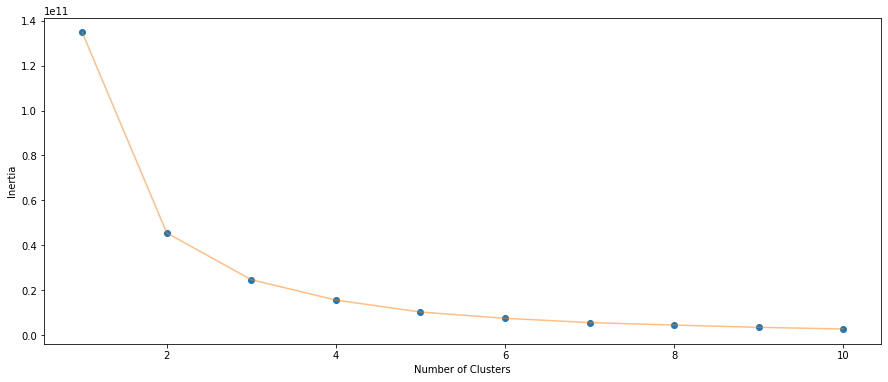

In [6]:
# KIndex 中存入用于聚类的特征索引
KIndex = np.array(['PREDDEG','CONTROL','HBCU','PBI','ANNHI','TRIBAL','AANAPII','HSI','NANTI','MENONLY','WOMENONLY','DISTANCEONLY','UGDS','PPTUG_EF','PCTFLOAN','PCTPELL'])

# 完善索引表，用这些数据来进行聚类
KIndex = np.append(KIndex,data3.columns.values[15:52])                                        
KIndex = np.append(KIndex,data3.columns.values[55:64])                                        

# 使用 Kdata 替代原数据集
Kdata = data3[KIndex]                                                                        

# 缺失值用 0 填充
X3 = Kdata.fillna(0).iloc[: , :].values                                                    

# 创建一个空列表，用于存储每个聚类数量下的惯性值
inertia = []

# 遍历从 1 到 10 的聚类数量
for n in range(1 , 11):

    # 创建 KMeans 聚类算法的实例
    algorithm = (KMeans(n_clusters = n ,init = 'k-means++', n_init = 10 ,max_iter = 300, tol = 0.0001,  random_state = 111  , algorithm = 'elkan') )

    # 拟合模型到数据集 X3     
    algorithm.fit(X3)

    # 将当前聚类数量下的惯性值添加到 inertia 列表中
    inertia.append(algorithm.inertia_)

# 作出图以找到最佳分类个数                                              
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

# K 均值聚类，其中类别标签保存在参数列表 labels3 中
algorithm = (KMeans(n_clusters = 5 ,init = 'k-means++', n_init = 10 ,max_iter = 300, tol = 0.0001,  random_state = 111  , algorithm = 'elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

## 求出各类别下目标特征值的平均值
'Net Price','RetentionRate','GRAD_DEBT_MDN_SUPP','GRAD_DEBT_MDN10YR_SUPP','RPY_3YR_RT_SUPP','gt_25k_p6','md_earn_wne_p10'

In [7]:
# 将聚类标签 'labels3' 分配给 data3 数据框的新列 'label'
data3['label'] = labels3

# 将 data3 数据框中所有值为 'PrivacySuppressed' 的单元格替换为 NaN
data3.replace('PrivacySuppressed',np.nan,inplace = True)

# 需要插值的索引
imputIndex = ['Net Price','RetentionRate','GRAD_DEBT_MDN_SUPP','GRAD_DEBT_MDN10YR_SUPP','RPY_3YR_RT_SUPP','gt_25k_p6','md_earn_wne_p10','PCTPELL','PCTFLOAN','SAT','label','UGDS']         

# 存放各组特征值的平均值
imputAvg = np.zeros(shape = (5,12))        

# 实际上只需要对前五个插值
for i in range(5):                                                                             
    temp = data3[data3['label'] == i]
    for j in range(len(imputIndex) - 1):
        AvgOfImput = temp[imputIndex[j]].mean()

        #保存指标的平均值，有不用的数据，比如label的均值
        imputAvg[i][j] = AvgOfImput     

#输出 data3 数据框的信息，包括列名、数据类型、非空值的数量等
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 0 to 2935
Data columns (total 79 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNITID                  2908 non-null   int64  
 1   PREDDEG                 2908 non-null   int64  
 2   CONTROL                 2908 non-null   int64  
 3   LOCALE                  2908 non-null   float64
 4   HBCU                    2908 non-null   float64
 5   PBI                     2908 non-null   float64
 6   ANNHI                   2908 non-null   float64
 7   TRIBAL                  2908 non-null   float64
 8   AANAPII                 2908 non-null   float64
 9   HSI                     2908 non-null   float64
 10  NANTI                   2908 non-null   float64
 11  MENONLY                 2908 non-null   float64
 12  WOMENONLY               2908 non-null   float64
 13  RELAFFIL                745 non-null    float64
 14  PCIP01                  2908 non-null   float

## 插值

最后得到没有缺失值的数据集


In [8]:
# 把各个聚类中的组分开
group_0 = data3[data3['label'] == 0]
group_1 = data3[data3['label'] == 1]
group_2 = data3[data3['label'] == 2]
group_3 = data3[data3['label'] == 3]    
group_4 = data3[data3['label'] == 4]                                           

# 求出 Risk 值
Risk = np.zeros(5)
Risk[0] = group_0['md_earn_wne_p10'].std()/group_0['md_earn_wne_p10'].mean()
Risk[1] = group_1['md_earn_wne_p10'].std()/group_1['md_earn_wne_p10'].mean()
Risk[2] = group_2['md_earn_wne_p10'].std()/group_2['md_earn_wne_p10'].mean()
Risk[3] = group_3['md_earn_wne_p10'].std()/group_3['md_earn_wne_p10'].mean()
Risk[4] = group_4['md_earn_wne_p10'].std()/group_4['md_earn_wne_p10'].mean()

# 插值
group_0 = pd.concat([group_0,group_1])
for i in range(0,9):
    group_0[imputIndex[i]].replace(np.nan,imputAvg[0][i],inplace = True)
    group_1[imputIndex[i]].replace(np.nan,imputAvg[1][i],inplace = True)
    group_2[imputIndex[i]].replace(np.nan,imputAvg[2][i],inplace = True)
    group_3[imputIndex[i]].replace(np.nan,imputAvg[3][i],inplace = True)
    group_4[imputIndex[i]].replace(np.nan,imputAvg[4][i],inplace = True)

# 合并      
group_0 = pd.concat([group_0,group_2])
group_0 = pd.concat([group_0,group_3])
group_0 = pd.concat([group_0,group_4])  

# 加上 UNITID 后的 data4 是比较完整的数据集                                      
data4 = group_0
imputIndex.append('UNITID')                                                 
data4 = data4[imputIndex]

# 输出 data4 数据框的信息，包括列名、数据类型、非空值的数量等
data4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 0 to 2770
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Net Price               2908 non-null   float64
 1   RetentionRate           2908 non-null   float64
 2   GRAD_DEBT_MDN_SUPP      2908 non-null   float64
 3   GRAD_DEBT_MDN10YR_SUPP  2908 non-null   float64
 4   RPY_3YR_RT_SUPP         2908 non-null   float64
 5   gt_25k_p6               2908 non-null   float64
 6   md_earn_wne_p10         2908 non-null   float64
 7   PCTPELL                 2908 non-null   float64
 8   PCTFLOAN                2908 non-null   float64
 9   SAT                     1434 non-null   float64
 10  label                   2908 non-null   int32  
 11  UGDS                    2908 non-null   float64
 12  UNITID                  2908 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 306.7 KB


## 归一化
使用极差变换法进行操作

In [9]:
# 化为数值
data5 = data4.values      

# 用极差变换法进行向量归一化
for j in range(10):
    data5[:,j] = (data5[:,j]-min(data5[:,j]))/(max(data5[:,j])-min(data5[:,j]))

# 从 data5 创建一个新的 DataFrame，并指定所需的列
data5 = pd.DataFrame(data5,columns = ['Net Price','RetentionRate','GRAD_DEBT_MDN_SUPP','GRAD_DEBT_MDN10YR_SUPP','RPY_3YR_RT_SUPP','gt_25k_p6','md_earn_wne_p10','PCTPELL','PCTFLOAN','SAT','label','UGDS','UNITID'])

## 主成分分析
先分析数据分布

有两个图呈现双峰状态

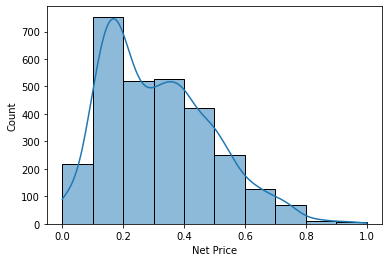

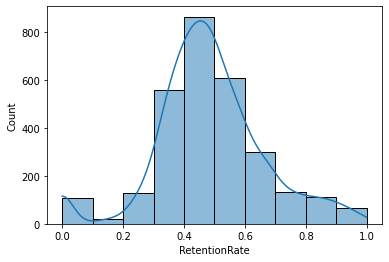

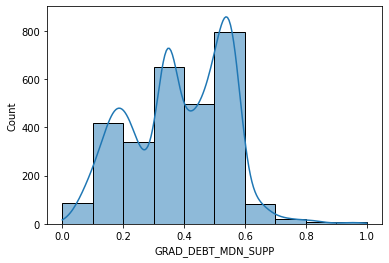

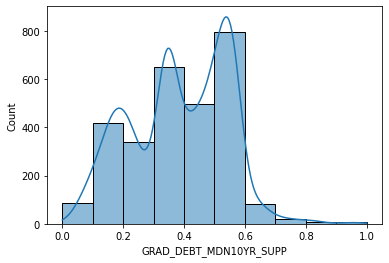

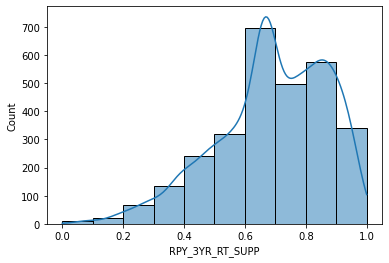

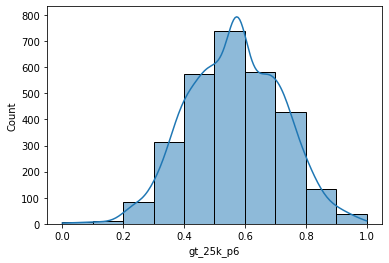

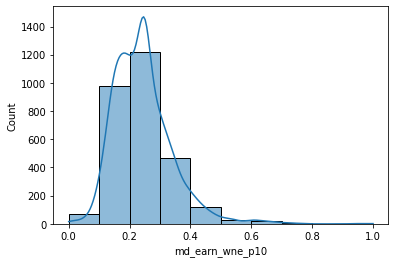

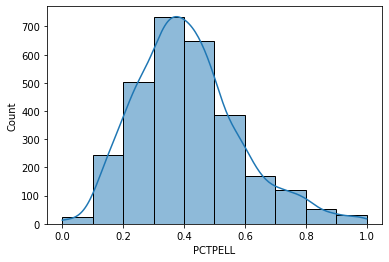

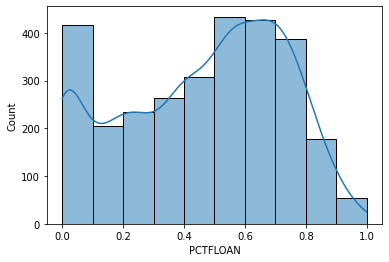

In [10]:
# 删除 'UNITID', 'SAT', 'label', 'UGDS' 列，并获取剩余列的名称
columns_n = data5.drop(columns = ['UNITID','SAT','label','UGDS']).columns

# 对每一列绘制直方图
for column in columns_n:

  # 使用 seaborn 绘制直方图，设置 bin 数量为 10，kde=True 表示绘制核密度估计曲线
  sns.histplot(data5[column] ,bins = 10,kde = True)

  # 显示图表
  plt.show()

In [11]:
# 保存柱状图数据，用于优化绘图
# pd.DataFrame(data5.drop(columns=['UNITID','SAT','label','UGDS']).iloc[:,:6]).to_csv('bar1.tsv', sep="\t")
# pd.DataFrame(data5.drop(columns=['UNITID','SAT','label','UGDS']).iloc[:,7:]).to_csv('bar2.tsv', sep="\t")


现计算相关系数矩阵

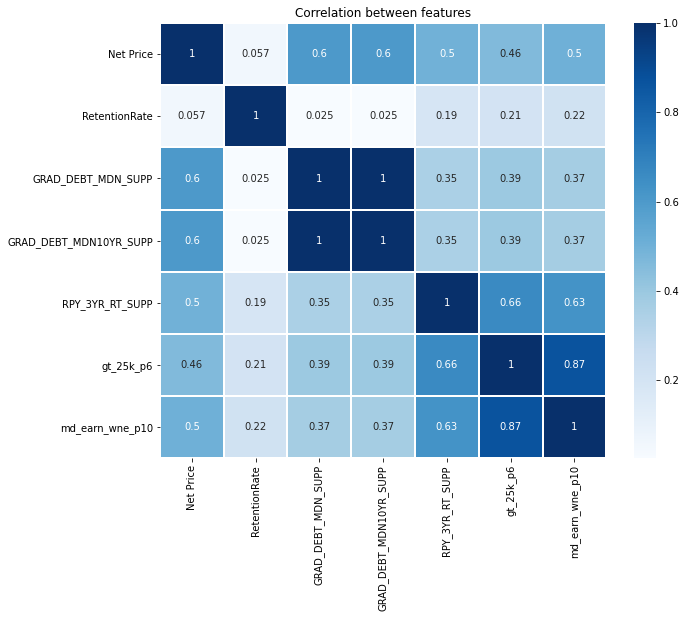

In [12]:
# 创建一个大小为 10x8 的子图
f, ax = plt.subplots(figsize = (10, 8))

# 删除指定列后计算数据框的 Pearson 相关系数矩阵
corr = data5.drop(columns = ['UNITID','SAT','label','UGDS','PCTPELL','PCTFLOAN']).corr(method="pearson")

# 使用 seaborn 绘制热力图，显示相关系数矩阵
sns.heatmap(corr,cmap = "Blues", linewidths = 0.05, annot = True,ax = ax)

# 设置图表标题
ax.set_title('Correlation between features') 

# 显示图表
plt.show()

In [13]:
# 保存热力图数据，用于优化绘图
# print(corr)
# corr.to_csv('file.tsv', sep="\t")

分析线性相关性强的组合

<Axes: xlabel='gt_25k_p6', ylabel='md_earn_wne_p10'>

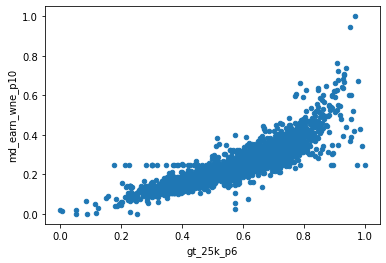

In [14]:
# 将 'gt_25k_p6' 和 'md_earn_wne_p10' 列从 data5 数据框中提取并拼接成新的数据框 data_a
data_a = pd.concat([data5['gt_25k_p6'], data5['md_earn_wne_p10']], axis = 1)

# 绘制 data_a 数据框的散点图，x 轴为 'gt_25k_p6'，y 轴为 'md_earn_wne_p10'
data_a.plot.scatter(x = 'gt_25k_p6', y = 'md_earn_wne_p10')

<Axes: xlabel='GRAD_DEBT_MDN_SUPP', ylabel='GRAD_DEBT_MDN10YR_SUPP'>

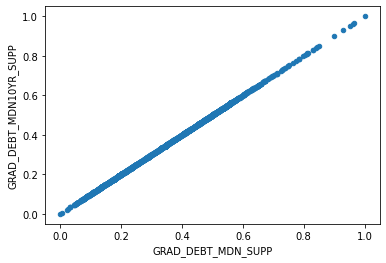

In [15]:
# 将 'GRAD_DEBT_MDN_SUPP' 和 'GRAD_DEBT_MDN10YR_SUPP' 列从 data5 数据框中提取并拼接成新的数据框 data_b
data_b = pd.concat([data5['GRAD_DEBT_MDN_SUPP'], data5['GRAD_DEBT_MDN10YR_SUPP']], axis = 1)

# 绘制 data_b 数据框的散点图，x 轴为 'GRAD_DEBT_MDN_SUPP'，y 轴为 'GRAD_DEBT_MDN10YR_SUPP'
data_b.plot.scatter(x = 'GRAD_DEBT_MDN_SUPP', y = 'GRAD_DEBT_MDN10YR_SUPP')

<Axes: xlabel='gt_25k_p6', ylabel='RPY_3YR_RT_SUPP'>

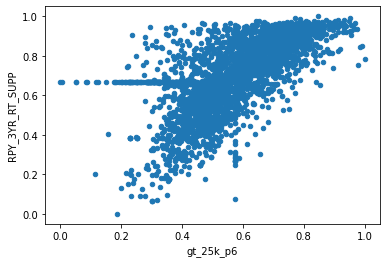

In [16]:
# 将 'gt_25k_p6' 和 'RPY_3YR_RT_SUPP' 列从 data5 数据框中提取并拼接成新的数据框 data_c
data_c = pd.concat([data5['gt_25k_p6'], data5['RPY_3YR_RT_SUPP']], axis = 1)

# 绘制 data_c 数据框的散点图，x 轴为 'gt_25k_p6'，y 轴为 'RPY_3YR_RT_SUPP'
data_c.plot.scatter(x = 'gt_25k_p6', y = 'RPY_3YR_RT_SUPP')

In [17]:
# 保存散点图数据，用于优化绘图
# s1 = data_a
# s1.rename(columns={'gt_25k_p6':'x','md_earn_wne_p10':'y'},inplace=True)
# s1.insert(loc=len(s1.columns), column='group', value='gt_25k_p6 & md_earn_wne_p10')
# s1.reset_index(drop=True, inplace=True) 
# s2 = data_b
# s2.rename(columns={'GRAD_DEBT_MDN_SUPP':'x','GRAD_DEBT_MDN10YR_SUPP':'y'},inplace=True)
# s2.insert(loc=len(s2.columns), column='group', value='GRAD_DEBT_MDN_SUPP & GRAD_DEBT_MDN10YR_SUPP')
# s2.reset_index(drop=True, inplace=True) 
# s3 = data_c
# s3.rename(columns={'gt_25k_p6':'x','RPY_3YR_RT_SUPP':'y'},inplace=True)
# s3.insert(loc=len(s3.columns), column='group', value='gt_25k_p6 & RPY_3YR_RT_SUPP')
# s3.reset_index(drop=True, inplace=True) 
# s=pd.concat([s1,s2,s3],axis=0)
# s.reset_index(drop=True,inplace=True)
# s.to_csv('s.tsv', sep="\t")

有几组线性相关性较强，提取主因子后用PCA降维

In [18]:
# 将 data5 数据框复制到 data6 中，并用 0 填补所有缺失值
data6 = data5.copy()
data6.fillna(0,inplace = True)

# 提取除最后四列外的所有列作为特征数据
data_n = data6.values[:,:8]

# 对特征数据进行标准化处理
sc = StandardScaler()
norm = sc.fit_transform(data_n)

# 构造并拟合 PCA 模型
model = PCA().fit(norm) 
print('特征值是：\n', model.explained_variance_)
print('各主成分贡献率：\n', model.explained_variance_ratio_)
print(model.explained_variance_ratio_[0:4].sum())

# 前三个指标贡献率已经 80+% 了，选三个指标
print(model.explained_variance_ratio_[0:3].sum())       


特征值是：
 [3.92421082e+00 1.71159867e+00 8.95181361e-01 5.43538906e-01
 4.39376848e-01 3.63923142e-01 1.24922227e-01 1.13586693e-31]
各主成分贡献率：
 [4.90357671e-01 2.13876261e-01 1.11859191e-01 6.79189994e-02
 5.49032194e-02 4.54747495e-02 1.56099086e-02 1.41934542e-32]
0.8840121223767601
0.81609312302159


## ROI模型的建立
### O(output)的四个组成
可以看到，前三个成分占比已经达到了 0.80+ 

由上述PCA分析可得三个主成分：Net Price，Retention Rate，RPY_3YR_RT_SUPP

使用md_earn_wne_p6代表SAG(毕业后薪水)

使用Retention Rate代表RR(留存收益率)

使用RPY_3YR_RT_SUPP代表RA(社会回报率)

使用归一化后的SAG减去SAT成绩再进行归一化代表EER（教育提高率）

如果某学校没有SAT成绩，则将此权重分给另外三个指标


使用AHP得到归一化后的特征向量

可以看到求出CR均小于0，有满意的一致性

In [19]:
# 计算矩阵 A 的一致性比率
a = array([[1,5,6,3],[1/5,1,2,1/2],[1/6,1/2,1,1/3],[1/3,2,3,1]])
L,V = eigs(a,1)
CR = (L-5)/4/1.12  
W = V/sum(V); print("最大特征值为：\n",L)
print("最大特征值对应的特征向量 W =\n",W)
print(CR)

# 计算矩阵 B 的一致性比率
b = array([[1,5,6],[1/5,1,2],[1/6,1/2,1]])
L,V = eigs(b,1)
CR = (L-5)/4/1.12  
W = V/sum(V); print("最大特征值为：\n",L)
print("最大特征值对应的特征向量 W =\n",W)
print(CR)

最大特征值为：
 [4.03396779+0.j]
最大特征值对应的特征向量 W =
 [[0.5767365 +0.j]
 [0.12505245+0.j]
 [0.07663486+0.j]
 [0.22157618+0.j]]
[-0.21563219+0.j]
最大特征值为：
 [3.02906377+0.j]
最大特征值对应的特征向量 W =
 [[0.72584831-0.j]
 [0.17211767-0.j]
 [0.10203403-0.j]]
[-0.43994112+0.j]


我们有两个权重向量V1,V2：
$$
V1=\begin{bmatrix}0.576,0.125,0.077,0.222 \end{bmatrix}
$$

$$
V2=\begin{bmatrix}0.726,0.172,0.102 \end{bmatrix}
$$

在计算Output值时，若一个学校的SAT成绩存在，则使用上面的算法，若不存在，则使用下面的算法

$$
Output=\begin{cases}V1\cdot \begin{bmatrix}SAG\quad RR \quad RA \quad EER \end{bmatrix}^T\\V2\cdot \begin{bmatrix}SAG\quad RR \quad RA  \end{bmatrix}^T\end{cases}
$$

## I(Input)的组成

$$
Input = (1-\alpha )+\alpha \times NP
$$
现在是ROI模型里的Input，这里取α=0.25，α起修正因子的作用

NP代表Net Price(净价)

## U(Urgency)的组成
主要考虑到我们提供援助是慈善活动，要考虑到被援助对象是否紧急

这里使用三个特征来描述对象的紧急性：
1. PCTPELL
2. PCTFLOAN
3. GRAD_DEBT_MDN_SUPP


下面对三个指标用AHP
$$V3 = [0.25 0.25 0.50]$$
$$
Urgency = V_3 \cdot \begin{bmatrix}PG\quad FL\quad Debt \end{bmatrix}^T
$$

In [20]:
# 将 'PCTPELL', 'PCTFLOAN', 'GRAD_DEBT_MDN_SUPP' 列从 data5 数据框中提取并拼接成新的数据框 Urgency
Urgency = pd.concat([data5['PCTPELL'],data5['PCTFLOAN'],data5['GRAD_DEBT_MDN_SUPP']], axis = 1)

# 输出 Urgency 数据框的信息，包括列名、数据类型、非空值的数量等
Urgency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2908 entries, 0 to 2907
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PCTPELL             2908 non-null   float64
 1   PCTFLOAN            2908 non-null   float64
 2   GRAD_DEBT_MDN_SUPP  2908 non-null   float64
dtypes: float64(3)
memory usage: 68.3 KB


## 灰色模型预测
在2015年的数据基础上，结合不同的学校的从2010-2014年五年内的数据

分别计算ROI，并用灰色模型预测

## MILF模型的建立

最后使用MILF和考虑时间序列

主要目的是最大化总回报，并且限制风险

### 定义风险
$$
r=\frac{\mu _e}{\sigma _e}
$$
其中$\mu _e$代表了md_earn_wne_p6的平均值，$\sigma _e$代表了md_earn_wne_p6的标准差



接下来计算出每个学校的ROI值和$\mu$值

先求Output值：

In [21]:
#去掉SAT里的缺失值，以使用apply函数
data5.fillna(0,inplace = True)           

def Output(x):

    #如果SAT值缺失了
    if(x['SAT'] != 0):                                        
        return 0.576*x['md_earn_wne_p10']+0.125*x['RetentionRate']+0.077*x['RPY_3YR_RT_SUPP']+0.222*x['SAT']
    
    #如果SAT值没有缺失，使用另外一种算法
    else:
        all = 0.576 + 0.125 + 0.077                               
        return 0.576*x['md_earn_wne_p10']/all + 0.125*x['RetentionRate']/all + 0.077*x['RPY_3YR_RT_SUPP']/all
    
# 对 data5 数据框逐行应用应用 Output 函数
data5['Output'] = data5.apply(Output, axis = 1)

再求 Input 值和 Urgency 值：

In [22]:
# 使用 lambda 函数计算 'Input' 列的值
data5['Input'] = data5.apply(lambda x:x['Net Price']*0.25*0.75,axis = 1)

# 使用 lambda 函数计算 'Urgency' 列的值
data5['Urgency'] = data5.apply(lambda x:0.25*x['PCTPELL'] + 0.25*x['PCTFLOAN'] + 0.5*x['GRAD_DEBT_MDN_SUPP'],axis = 1)

根据公式：
$$
ROI=\frac{Input}{Output}\times Urgency
$$
直接计算出 ROI 

再根据公式：
$$
r=\frac{\mu _e}{\sigma _e}
$$
计算出 Risk 值

在前面插值步骤已经求出了 Risk 数组，里面对应的就是 Risk 值

现在只需要再加入到数据中即可

In [23]:
# 求解 ROI
data5['ROI'] = data5.apply(lambda x:x['Input']/x['Output']*x['Urgency'],axis = 1)       

# 定义 CalRisk 函数用于计算风险值
def CalRisk(x):
    return Risk[int(x['label'])]

# 计算 Risk
data5['Risk'] = data5.apply(CalRisk,axis = 1)                                           

## 规划求解
$$
max\sum_{i\in S}ROI_ix_i\\ s.t.\begin{cases} \sum_{i\in S}x_i \leq A\\ \sum_{i\in S}r_ix_i\leq A\cdot r^{max}\\ N^{min}\leq 
\sum_{i\in S}y_i\leq N^{max}\\ A_i^{min}y_i\leq x_i\leq A_i^{min}y_i\quad \forall i\in S\\ s_iy_i\leq S^{min}\qquad \forall i \in S \end{cases}
$$


In [24]:
#筛选出人数大于1000的学校，学校人数过少，则援助的效果不明显
data5 = data5[data5['UGDS'] >= 1000]
data5.reset_index(drop = True,inplace = True)

#把ROI值转为列表
ROIs = data5['ROI'].tolist()
ROIs = np.array(ROIs)

#把学生数量值转为列表
Stus = data5['UGDS'].tolist()
Stus = np.array(Stus)

#定义各个量
A_min = 5000000
S_min = 1000
N_max = 20
N_min = 10
b = 3000
A = 100000000

#c1全1，c2里存取Risk值，r_max为可承受的最大风险
c1 = np.ones(len(Stus)).tolist()
c2 = data5['Risk'].tolist()
r_max = 1

##接下来使用SCIP模块求解##

#定义问题
model = Model("2016C_Q1")     

# 多变量求解的定义
x,y = {},{}     

# 添加变量             
for i in range(len(Stus)):  

    # x表示投资变量，下界为0，上界为正无穷，类型为连续值
    x[i] = model.addVar(lb = 0,ub = None,vtype = 'C',name = 'x' + str(i))  

    # y表示是否在投资列表内，下界为0，上界为1，类型为离散值（整型）     
    y[i] = model.addVar(lb = 0,ub = 1,vtype = 'I',name = 'y' + str(i))  

# 设置目标函数 
model.setObjective(quicksum(ROIs[i]*x[i] for i in range(len(Stus))),"maximize")   

# 总投资上界
model.addCons(quicksum(c1[i]*x[i] for i in range(len(Stus))) <= A)                 

# 总风险上界
model.addCons(quicksum(c2[i]*x[i] for i in range(len(Stus))) <= A*r_max)           

# 总推荐学校数上下界
model.addCons(quicksum(c1[i]*y[i] for i in range(len(Stus))) <= N_max)             
model.addCons(N_min <= (quicksum(c1[i]*y[i] for i in range(len(Stus)))))          

# 投资量限制上下界
for i in range(len(Stus)):
    model.addCons(A_min*y[i] <= x[i])
    model.addCons(x[i] <= (A_min+b*Stus[i])*y[i])                                   

# 求解问题
model.optimize()

# 输出最优值
print("Optimal value:", model.getObjVal())    


Optimal value: 38678068.72358386


In [25]:
#输出结果
results = model.getBestSol()

# 初始化空列表，用于存储优化结果
x_res0,y_res0 = [],[]

# 循环遍历学生数量
for i in range(len(Stus)):

    # 获取优化结果中 x 和 y 的值
    x_res0.append(model.getVal(x[i]))
    y_res0.append(model.getVal(y[i]))

# 将列表转换为 NumPy 数组
x_res = np.array(x_res0)
y_res = np.array(y_res0)

# 找出非零元素的索引
np.nonzero(x_res)

# 获取学校 UNITID 列的数据
data6 = data5['UNITID']

# 初始化列表
xs,ys = [],[]

# 遍历优化结果，筛选出符合条件的学校 UNITID 和对应的优化结果
for i in range(len(x_res)):
    if(x_res[i] > 0):
        xs.append(int(data6.loc[i]))
        ys.append(x_res[i])
        print(int(data6.loc[i]))
        print(x_res[i])
        print(' ')

199643
10769000.0
 
199582
8897000.0
 
406200
10289000.0
 
438151
12146000.0
 
217721
12536000.0
 
165802
10199000.0
 
136774
8759000.0
 
138947
12887000.0
 
220598
5002000.0
 
198862
8516000.0
 


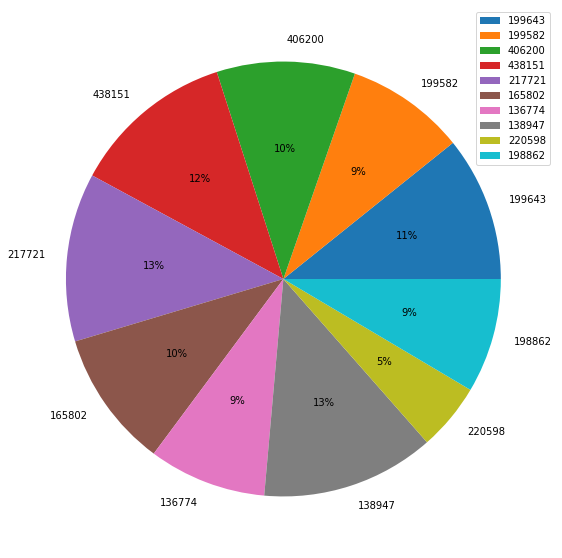

In [26]:
# 创建一个字典，将 xs 和 ys 列表合并为一个字典，用于饼图的绘制
pieplot = dict(zip(xs,ys))

# 创建一个大小为 (20, 10) 的图表
plt.figure(1 , figsize = (20 ,10))

# 绘制饼图，设置自动计算百分比并显示在图中，标签为 xs
plt.pie(ys,autopct = '%.f%%',labels = xs)

# 添加图例
plt.legend()

## 时间序列+未来五年规划


$$
max\sum_{i\in S}\sum_{t\in T}ROI_i^tx_i^t\\ s.t.\begin{cases} \sum_{i\in S}\sum_{t\in T}x_i^t \leq A\\ \sum_{i\in S}\sum_{t\in T}r_i^tx_i^t\leq A\cdot r^{max}\\ N^{min}\leq 
\sum_{i\in S}y_i^t\leq N^{max}\quad \forall t\in T\\ A_i^{min}y_i^t\leq x_i\leq A_i^{min}y_i^t\quad \forall t\in T ,\quad \forall i\in S\\ s_iy_i^t\leq S^{min}\qquad \forall t\in T ,\quad \forall i\in S \end{cases}
$$

In [27]:
#如果找不到历年数据，可先自行创建数据.在本文中，已成功找到历年ROI数据.
# import random
# ROIt=np.ones((5,len(Stus)))
# rt=np.ones((5,len(Stus)))
# for i in range(5):
#     for j in range(len(ROIs)):
#         ran=random.randint(-10,10)
#         ROIt[i][j]=ROIs[j]+0.0058*ran*i
# df=pd.DataFrame(ROIt)
# df.to_excel('ROI.xlsx')

In [28]:
# 从 Excel 文件 'ROI.xlsx' 中读取数据，并转换为 NumPy 数组
ROIt = pd.read_excel('ROI.xlsx')
ROIt = ROIt.to_numpy()[0:,1:]

# 将 'ROI' 列转换为列表，并转换为 NumPy 数组
ROIs = data5['ROI'].tolist()
ROIs = np.array(ROIs)

# 将 'UGDS' 列转换为列表，并转换为 NumPy 数组
Stus = data5['UGDS'].tolist()
Stus = np.array(Stus)

# 设置 A_min、S_min、N_max、N_min、b、A 等参数
A_min = 5000000
S_min = 1000
N_max = 10
N_min = 10
b = 3000
A = 100000000
c1 = np.ones(len(Stus)).tolist()
c2 = data5['Risk'].tolist()
r_max = 1

# 初始化结果列表
results_df = []

for years in range(1,6,1):
    model = Model("2016C_Q2")
    xt,yt = [{} for i in range(years)],[{} for i in range(years)]

    # 添加决策变量
    for i in range(years):
        for j in range(len(Stus)):
            xt[i][j] = model.addVar(lb = 0,ub = None,vtype = 'C',name = 'x' + str(j) + 'year' + str(i))
            yt[i][j] = model.addVar(lb = 0,ub = 1,vtype = 'I',name='y' + str(j) + 'year' + str(i))
    
    # 设置目标函数
    model.setObjective(quicksum(ROIt[i][j]*xt[i][j] for i in range(years) for j in range(len(Stus))),sense = "maximize")

    # 添加约束条件  
    for i in range(years): 
        model.addCons(quicksum(c1[j]*xt[i][j] for j in range(len(Stus))) <= A)
    model.addCons(quicksum(c2[j]*xt[i][j] for i in range(years) for j in range(len(Stus))) <= A*r_max)
    for t in range(years):
        model.addCons(N_min <= quicksum(c1[j]*yt[t][j] for j in range(len(Stus))))
        model.addCons(quicksum(c1[j]*yt[t][j] for j in range(len(Stus))) <= N_max)
    for j in range(len(Stus)):
        for i in range(years):
            model.addCons(A_min*yt[i][j] <= xt[i][j])
            model.addCons(xt[i][j] <= (A_min+b*Stus[j])*yt[i][j])
    
    # 求解模型
    model.optimize()

    print("Optimal value:", model.getObjVal())
    results = model.getBestSol()
    data6 = data5['UNITID']

     # 保存每一年的投资结果
    for t in range(years):
        year_data = {'UNITID': [], 'Investment': []}
        for j in range(len(Stus)):
            if model.getVal(xt[t][j]) > 0:
                year_data['UNITID'].append(int(data6.loc[j]))
                year_data['Investment'].append(model.getVal(xt[t][j]))
    results_df.append(pd.DataFrame(year_data))

# 将结果写入 Excel 文件
with pd.ExcelWriter('result_5years.xlsx') as writer:
    for i in range(5):
        results_df[i].to_excel(writer, sheet_name = 'year'+str(2017+i))

Optimal value: 38678068.72358386
Optimal value: 77924290.10464874
Optimal value: 121111711.64057676
Optimal value: 142882739.26200113
Optimal value: 148701907.32624024


## 灵敏度分析
文中给了以下三种分析：

### 改变风险接受度
调整 r_max (最大可承受风险)
### 改变最小投资步长
分析最优值的大小变化
### 改变投资策略
在时间策略模型下分别用这四种投资方案来跑：
1. 三年全投资完
2. 给一个学校的投资平均到每年
3. 每年随便投资，不加限制
4. 每年投资分配不均匀，但是规定了上下界


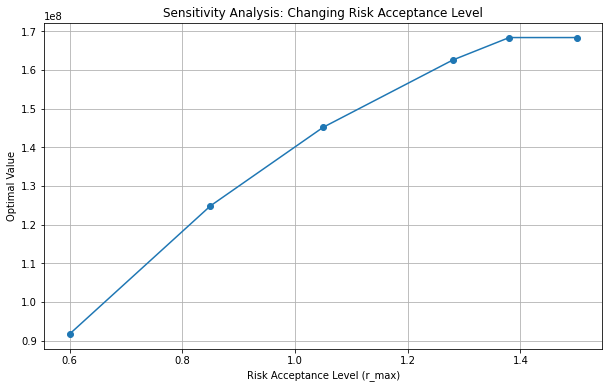

In [29]:
# 定义优化投资策略函数，考虑风险
def optimize_investment_strategy_risk(years, A, b, Stus, ROIs, A_min, N_min, N_max, r_max, strategy, lower_bound=0, upper_bound=np.inf):
    
    # 创建优化模型
    model = Model("investment_strategy")
    
    # 创建变量字典
    xt, yt = [{} for _ in range(years)], [{} for _ in range(years)]
    
    # 添加变量和约束
    for t in range(years):
        for j in range(len(Stus)):

            # 投资额度变量 xt
            xt[t][j] = model.addVar(lb=0, ub=None, vtype='C', name='x{}_year{}'.format(j, t))

            # 二进制变量 yt，表示是否选择该投资
            yt[t][j] = model.addVar(lb=0, ub=1, vtype='I', name='y{}_year{}'.format(j, t))
    
    # 设置优化目标：最大化投资回报
    model.setObjective(quicksum(ROIs[t][j] * xt[t][j] for t in range(years) for j in range(len(Stus))), sense="maximize")
    
    # 添加约束：总投资额不超过 A
    for t in range(years):
            model.addCons(quicksum(xt[t][j] for j in range(len(Stus))) <= A )

    # 添加约束：考虑风险限制
    model.addCons(quicksum(xt[t][j] * data5['Risk'][j] for t in range(years) for j in range(len(Stus))) <= A * r_max)
    
    # 添加约束：选择的投资项目数量范围
    for t in range(years):
        model.addCons(N_min <= quicksum(yt[t][j] for j in range(len(Stus))))
        model.addCons(quicksum(yt[t][j] for j in range(len(Stus))) <= N_max)
    
    # 根据策略添加约束：三种不同的投资策略
    for j in range(len(Stus)):
        for t in range(years):
            if strategy == "three_year":
                if t < 3:
                    model.addCons(A_min * yt[t][j] <= xt[t][j])
                else:
                    model.addCons(xt[t][j] == 0)
            elif strategy == "equal_yearly":
                model.addCons(A_min * yt[t][j] <= xt[t][j])
                model.addCons(xt[t][j] == xt[0][j])
            elif strategy == "bounded":
                model.addCons(lower_bound * yt[t][j] <= xt[t][j])
                model.addCons(xt[t][j] <= upper_bound * yt[t][j])
            elif strategy == "unrestricted":
                model.addCons(A_min * yt[t][j] <= xt[t][j])
                model.addCons(xt[t][j] <= ( A_min + b*Stus[j])*yt[t][j])
    
    # 求解优化模型
    model.optimize()
    
    # 检查优化状态，如果非最优或可行解则输出警告信息
    if model.getStatus() not in ['optimal', 'feasible']:
        print(f"Strategy {strategy} not solved to optimality. Status: {model.getStatus()}")
        return None
    
    # 返回优化目标值
    return model.getObjVal()

# 定义风险敏感性分析函数
def sensitivity_analysis_risk(risk_levels):
    optimal_values = []
    for r_max in risk_levels:

        # 调用优化投资策略函数，分析不同风险水平下的最优值
        opt_val = optimize_investment_strategy_risk(5, A, b, Stus, ROIs, A_min, N_min, N_max, r_max, 'unrestricted')
        if opt_val is not None:
            optimal_values.append(opt_val)
    
    # 绘制敏感性分析结果图像
    plt.figure(figsize=(10, 6))
    plt.plot(risk_levels, optimal_values, marker='o')
    plt.title('Sensitivity Analysis: Changing Risk Acceptance Level')
    plt.xlabel('Risk Acceptance Level (r_max)')
    plt.ylabel('Optimal Value')
    plt.grid(True)
    plt.show()

# 复制数据并准备参数
A = 100000000
b = 3000
A_min = 5000000
N_min = 6
N_max = 6
data6 = data5.copy()
Stus = data6['UGDS'].tolist()
Stus = np.array(Stus)
ROIs = [data6['ROI'].tolist() for _ in range(5)]
ROIs = np.array(ROIs)

# 指定风险水平范围进行风险敏感性分析
risk_levels = [0.6,0.85,1.05,1.28,1.38,1.5]
sensitivity_analysis_risk(risk_levels)


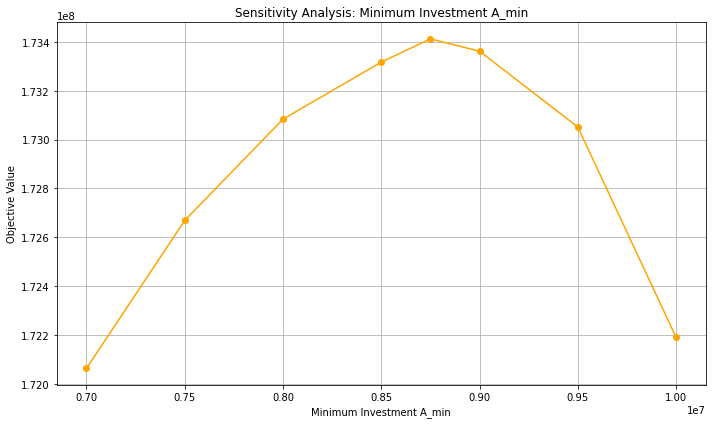

In [30]:
# 读取数据
ROIt = pd.read_excel('ROI.xlsx').to_numpy()[:, 1:]
ROIs = np.array(data5['ROI'].tolist())
Stus = np.array(data5['UGDS'].tolist())
c1 = np.ones(len(Stus)).tolist()
c2 = data5['Risk'].tolist()

# 准备参数
r_max = 1.3
N_max = 7
N_min = 7
b = 3000

# 定义最小投资金额 A_min 的不同取值范围
A_min_values = [7000000,7500000,8000000,8500000,8750000,9000000,9500000,10000000]

# 存储灵敏度分析结果
sensitivity_results_A_min = []

# 对每个 A_min 进行灵敏度分析

# 总投资金额
A = 100000000 

# 投资年限
years = 5
for A_min in A_min_values:

    # 创建优化模型
    model = Model("sensitivity_analysis_A_min")
    xt, yt = [{} for _ in range(years)], [{} for _ in range(years)]
    
    # 添加变量和约束
    for i in range(years):
        for j in range(len(Stus)):
            xt[i][j] = model.addVar(lb=0, ub=None, vtype='C', name='x'+str(j)+'year'+str(i))
            yt[i][j] = model.addVar(lb=0, ub=1, vtype='I', name='y'+str(j)+'year'+str(i))
    
    # 设置优化目标：最大化投资回报
    model.setObjective(quicksum(ROIt[i][j] * xt[i][j] for i in range(years) for j in range(len(Stus))), sense="maximize")
    
    # 添加约束：总投资额不超过 A
    for i in range(years):
        model.addCons(quicksum(c1[j] * xt[i][j] for j in range(len(Stus))) <= A / r_max)
    
    # 添加约束：考虑风险限制
    model.addCons(quicksum(c2[j] * xt[i][j] for i in range(years) for j in range(len(Stus))) <= A * r_max)
    
    # 添加约束：投资项目数量范围
    for t in range(years):
        model.addCons(N_min <= quicksum(c1[j] * yt[t][j] for j in range(len(Stus))))
        model.addCons(quicksum(c1[j] * yt[t][j] for j in range(len(Stus))) <= N_max)
    
    # 添加约束：根据 A_min 和 b 进行投资金额的限制
    for j in range(len(Stus)):
        for i in range(years):
            model.addCons(A_min * yt[i][j] <= xt[i][j])
            model.addCons(xt[i][j] <= (A_min + b * Stus[j]) * yt[i][j])

    # 求解优化模型      
    model.optimize()
    
    # 如果求解成功，存储优化目标值；否则存储 None
    if model.getStatus() == "optimal":
        obj_val = model.getObjVal()
        sensitivity_results_A_min.append({'A_min': A_min, 'Objective': obj_val})
    else:
        sensitivity_results_A_min.append({'A_min': A_min, 'Objective': None})

# 将结果转换为DataFrame
sensitivity_df_A_min = pd.DataFrame(sensitivity_results_A_min)

# 绘制灵敏度分析图表
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sensitivity_df_A_min['A_min'], sensitivity_df_A_min['Objective'], marker='o', color='orange')
ax.set_xlabel('Minimum Investment A_min')
ax.set_ylabel('Objective Value')
ax.set_title('Sensitivity Analysis: Minimum Investment A_min')
ax.grid(True)
plt.tight_layout()
plt.show()

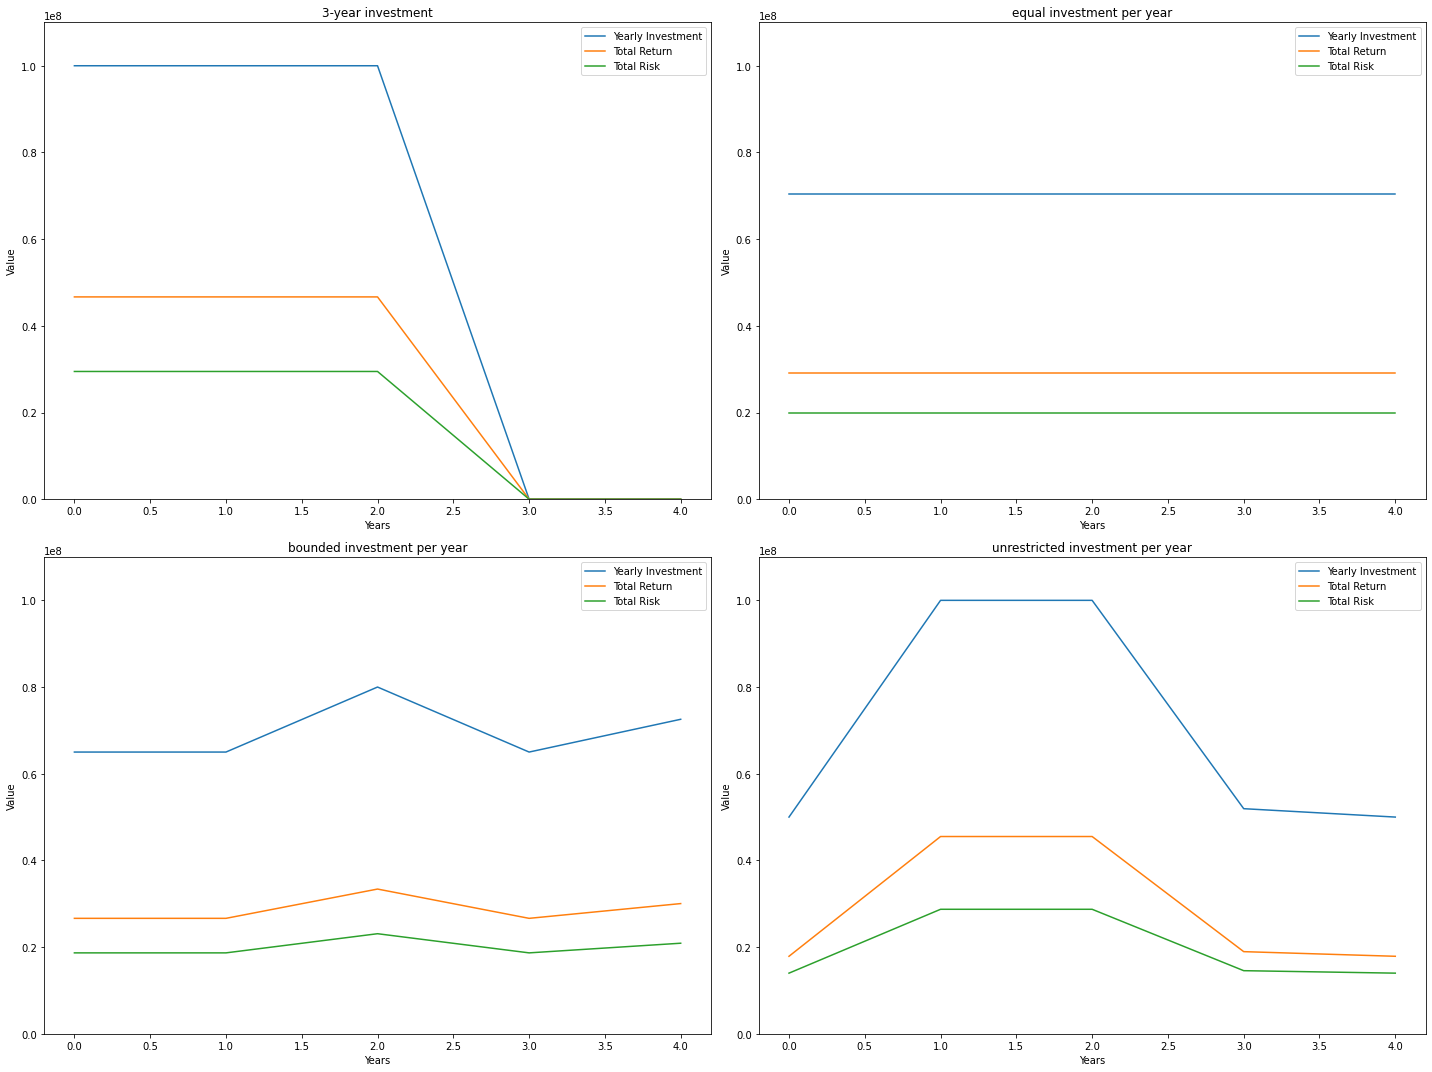

In [31]:
# 定义优化函数
def optimize_investment_strategy(years, A, b, Stus, ROIs, A_min, N_min, N_max, r_max, strategy, lower_bound=0, upper_bound=np.inf):
    
    """
    优化投资策略的函数。

    参数:
    - years: 投资年限
    - A: 总投资金额
    - b: 相关参数
    - Stus: 学生数量数组
    - ROIs: 投资回报率数组
    - A_min: 最小投资金额
    - N_min: 最小投资数量
    - N_max: 最大投资数量
    - r_max: 风险接受水平
    - strategy: 投资策略类型 ('three_year', 'equal_yearly', 'unrestricted', 'bounded')
    - lower_bound: 下界（仅对 'bounded' 策略有效）
    - upper_bound: 上界（仅对 'bounded' 策略有效）

    返回值:
    - 如果成功优化，返回投资分配的二维数组 xt_vals，否则返回 None。
    """

    model = Model("investment_strategy")
    xt, yt = [{} for _ in range(years)], [{} for _ in range(years)]
    
    # 定义决策变量
    for t in range(years):
        for j in range(len(Stus)):
            xt[t][j] = model.addVar(lb=0, ub=None, vtype='C', name='x{}_year{}'.format(j, t))
            yt[t][j] = model.addVar(lb=0, ub=1, vtype='I', name='y{}_year{}'.format(j, t))
    
    # 设置优化目标
    model.setObjective(quicksum(ROIs[t][j] * xt[t][j] for t in range(years) for j in range(len(Stus))), sense="maximize")
    
    # 添加约束条件
    for t in range(years):
        model.addCons(quicksum(xt[t][j] for j in range(len(Stus))) <= A)
    
    model.addCons(quicksum(xt[t][j] * data5['Risk'][j] for t in range(years) for j in range(len(Stus))) <= A * r_max)
    
    for t in range(years):
        model.addCons(N_min <= quicksum(yt[t][j] for j in range(len(Stus))))
        model.addCons(quicksum(yt[t][j] for j in range(len(Stus))) <= N_max)
    
    for j in range(len(Stus)):
        for t in range(years):
            if strategy == "three_year":
                if t < 3:
                    model.addCons(A_min * yt[t][j] <= xt[t][j])
                else:
                    model.addCons(xt[t][j] == 0)
            elif strategy == "equal_yearly":
                model.addCons(A_min * yt[t][j] <= xt[t][j])
                model.addCons(xt[t][j] == xt[0][j])
            elif strategy == "unrestricted":
                model.addCons(A_min * yt[t][j] <= xt[t][j])
            elif strategy == "bounded":
                model.addCons(lower_bound * yt[t][j] <= xt[t][j])
                model.addCons(xt[t][j] <= upper_bound * yt[t][j])

    # 进行优化    
    model.optimize()
    
    # 检查优化结果
    if model.getStatus() not in ['optimal', 'feasible']:
        print(f"Strategy {strategy} not solved to optimality. Status: {model.getStatus()}")
        return None
    
    # 获取最优解的值
    xt_vals = [[model.getVal(xt[t][j]) for j in range(len(Stus))] for t in range(years)]
    return xt_vals

# 定义绘图函数
def plot_sensitivity_analysis(strategies,results,labels, y_max=1e8):

    """
    绘制灵敏度分析图表的函数。

    参数:
    - strategies: 不同投资策略及其参数的字典
    - results: 不同策略的优化结果
    - labels: 图表的标签
    - y_max: y 轴的最大值

    返回值:
    - None
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    axs = axs.ravel()
    for i, (strategy, xt_vals) in enumerate(results.items()):
        if xt_vals is None:
            continue
        
        # 计算投资年限、总回报和总风险
        year_investment = [sum(xt_vals[t]) for t in range(len(xt_vals))]
        total_return = [sum(ROIs[t][j] * xt_vals[t][j] for j in range(len(Stus))) for t in range(len(xt_vals))]
        total_risk = [sum(data5['Risk'][j] * xt_vals[t][j] for j in range(len(Stus))) for t in range(len(xt_vals))]
        
        # 绘制图表
        axs[i].plot(range(len(year_investment)), year_investment, label='Yearly Investment')
        axs[i].plot(range(len(total_return)), total_return, label='Total Return')
        axs[i].plot(range(len(total_risk)), total_risk, label='Total Risk')
        axs[i].set_ylim(0, y_max)
        axs[i].set_title(strategy)
        axs[i].set_xlabel('Years')
        axs[i].set_ylabel('Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# 数据准备
A = 100000000
b = 3000
A_min = 5000000
N_min = 10
N_max = 10
r_max = 1
lower_bound = A_min
upper_bound = A * 0.2

data6 = data5.copy()
Stus = data6['UGDS'].tolist()
Stus = np.array(Stus)
ROIs = [data6['ROI'].tolist() for _ in range(5)]
ROIs = np.array(ROIs)

# 定义不同策略及其参数
strategies = {
    '3-year investment': {'years': 5, 'strategy': 'three_year'},
    'equal investment per year': {'years': 5, 'strategy': 'equal_yearly'},
    'bounded investment per year': {'years': 5, 'strategy': 'bounded', 'lower_bound': lower_bound, 'upper_bound': upper_bound},
    'unrestricted investment per year': {'years': 5, 'strategy': 'unrestricted'}
}

# 执行优化和绘图
results = {}
for strategy_name, params in strategies.items():
    if 'lower_bound' in params and 'upper_bound' in params:
        results[strategy_name] = optimize_investment_strategy(params['years'], A, b, Stus, ROIs, A_min, N_min, N_max, r_max, params['strategy'], params['lower_bound'], params['upper_bound'])
    else:
        results[strategy_name] = optimize_investment_strategy(params['years'], A, b, Stus, ROIs, A_min, N_min, N_max, r_max, params['strategy'])

plot_sensitivity_analysis(strategies, results, labels=["Yearly Investment", "Total Return", "Total Risk"], y_max=1.1e8)